<div style="text-align: right"><strong>Capstone #3:</strong> <span style="color:darkred">Supervised Learning</span> </div>

<a id="top"></a>

 ---------

# <span style="color:darkblue">L1 Prediction from ELL Writing Samples </span>

__Author:__ Ryan Harper 

----

<a href='#ov'>Overview</a><br>
<a href='#exp'>Experiment</a><br>
<a href='#sec1'>1. Cleaning Data</a><br>
<a href='#sec2'>2. Exploring the Data</a><br>
<a href='#sec3'>3. Models:</a><br>
><a href='#seca'>A. LR - Ordinary Least Squares</a><br>
<a href='#secb'>B. LR - Logistic Regression</a> <a href='#secb1'> (Lasso)</a> <a href='#secb2'> (Ridge)</a><br>
<a href='#secc'>C. NN - K Nearest Neighbors</a><br>
<a href='#secd'>D. NN - Naive Bayes</a><br>
<a href='#sece'>E. NN - Decision Tree</a><br>
<a href='#secf'>F. Ensemble - Random Forest</a><br>

<a href='#sec4'>4. Model Comparison</a><br>

<a id="ov"></a>

# <span style="color:darkblue">Overview</span>  <a href='#top'>(top)</a>

__Data Source:__
> http://lang-8.com/ [scraped with Beautiful Soup]

![alt text](../data/language/lang8.png "Title")

__Summary:__
> In my previous profession, I have been teaching English to a diverse range of students of all ages, language background, and country origin. During my professional development, I started to observe that different students with different L1s (1st Language) tended to display different patterns of communication that appeared to have some connection to either education in their country of origin or a connection to the linguistic structure of their first language. Different ELL (English Language Learners) needed to focus on different aspects of the English language depending on their background. The purpose of this project is to use a large number of blog posts from a language practicing website and explore whether or not the L1 has any significant impact on the blog writing style of the English learner.<br><br>Part 1: Explore the data to find any noteworthy trends in linguistic structure: <ol><li> vocabulary (word freq, collocations, and cognates) <li>syntax (sentence structure)<li>grammar (i.e. grammar complexity of sentences) <li>errors (types of errors) <li> parts of speech (NLTK Abbreviations: https://pythonprogramming.net/natural-language-toolkit-nltk-part-speech-tagging/)</ol><br>Part 2: Use linguistic trends to determine whether or not a learner's first language can be predicted.

__Variables:__
>__id:__ _User ID_<br>
__time:__ _Time the blog post was scraped (in order of user posted time)_ <br>
__title:__ _Title of the blog post_<br>
__content:__ _The blog post_<br>
__language:__ _User's self-reported first language_

<a id="exp"></a>

# <span style="color:darkblue">Experiment</span> <a href='#top'>(top)</a>

__Hypothesis:__ 
> L1 (first language) experience and academic environment influences ELLs' (English Language Learners') writing style. The L1 of ELLs can be predicted by looking at English blog posts and identifying patterns unique to their L1.

__Observations:__
><li> --<li>--<li>--

__Method:__
> Using multiple different models. The aim of this project is to explore how different models can handle the data (target and features) and to see what information can be gained from using multiple different models. Ultimately, the goal is to determine which models are appropriate for a binary (discrete) target with features that are both qualitative (discrete) and quantitative (ranked/continuous).

<a id="sec1"></a>

# <span style="color:darkblue">1. Cleaning the Data</span>  <a href='#top'>(top)</a>

In [1]:
# iPython/Jupyter Notebook
import time
from pprint import pprint
import warnings
from IPython.display import Image

# Data processing
import pandas as pd
import plotly as plo
import seaborn as sns
from scipy import stats
from collections import Counter

# NLP
from nltk.corpus import stopwords as sw
from nltk.util import ngrams
from nltk.corpus import brown
import nltk
import re
from nltk.tokenize import RegexpTokenizer
import difflib

# Preparing Models
from sklearn.model_selection import train_test_split

# Models
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.naive_bayes import BernoulliNB

# Ensemble
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

#Visualization
from IPython.display import Image
import pydotplus
import graphviz

# import altair as alt

In [2]:
# load and close files
def get_text(link):
    with open(link) as f:
        output = f.read()
    return output

In [3]:
# Jupyter Settings and Imports
%pylab
%matplotlib inline 
warnings.filterwarnings(action='once')

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [4]:
# Import data
blog = pd.read_csv('../data/language/blogdata-reduced.csv')
blog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14472 entries, 0 to 14471
Data columns (total 6 columns):
Unnamed: 0    14472 non-null int64
id            14472 non-null int64
time          14472 non-null object
title         14472 non-null object
content       14472 non-null object
language      14472 non-null object
dtypes: int64(2), object(4)
memory usage: 678.5+ KB


In [5]:
# Import data
blog = pd.read_csv('../data/language/blogdata-reduced.csv')

# Clean Data
del blog['Unnamed: 0']
blog.language = blog.language.mask(blog.language == 'Mandarin', 'Traditional Chinese').replace(['Persian', 'Arabic',
        'Bulgarian', 'Swedish', 'Slovenian', 'Slovak', 'Malay', 'Turkish','Romanian', 'Czech', 'Danish', 'Vietnamese',
        'Norwegian','Serbian','Other language','Lithuanian', 'Ukrainian', 'Finnish','Estonian','Bengali','Russian', 
        'Spanish','French', 'German', 'Cantonese','Mongolian', 'Tagalog', 'Polish', 'Dutch','Italian', 'Portuguese(Brazil)', 
        'Thai', 'Indonesian', 'Cantonese','Mongolian'], np.nan)
blog = blog.dropna()

In [6]:
blog.info(verbose=False, memory_usage=False,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13339 entries, 0 to 14471
Columns: 5 entries, id to language
dtypes: int64(1), object(4)

In [7]:
blog.head()

,id,time,title,content,language
0,1,2018-03-15 23:52:01.424272+00:00,I'm going to Silicon Valley!,I will visit Silicon Valley in California bet...,Japanese
1,1,2018-03-15 23:52:06.279421+00:00,Sightseeing in Kyoto,My parents want to take their Chinese guests ...,Japanese
2,1,2018-03-15 23:52:09.582504+00:00,Shaku-gan no SHANA,Do you know a Japanese animation (and novel) ...,Japanese
3,2,2018-03-16 00:00:59.456895+00:00,Unlucky,I went to watch a featherweight throne jump-o...,Japanese
4,2,2018-03-16 00:01:03.120751+00:00,Stone Art???,There is a traditional custum that a blood re...,Japanese


In [8]:
# Confirmation that there are no more null values
blog.isnull().values.any()

False

In [9]:
blog.language.unique()

array(['Japanese', 'Korean', 'Traditional Chinese', 'English'],
      dtype=object)

<a id="sec2"></a>

# <span style="color:darkblue">2. Exploring the Data</span>  <a href='#top'>(top)</a>

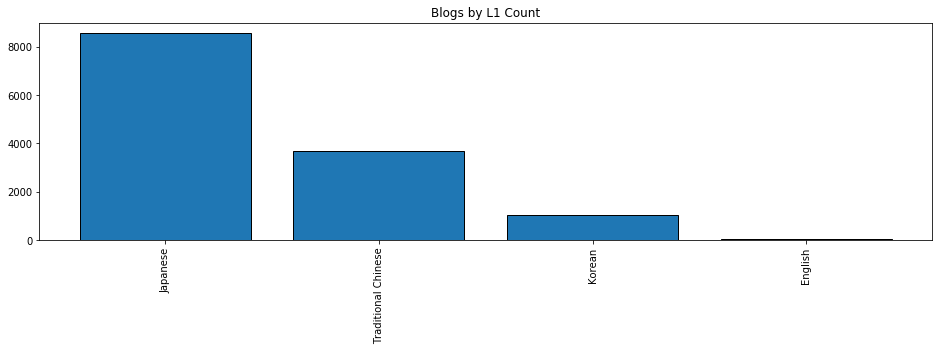

In [10]:
vals = list(blog.language.value_counts().values)
languages = list(blog.language.value_counts().index)
plt.figure(figsize(6,4))
plt.bar(languages,vals,edgecolor='black')
plt.title('Blogs by L1 Count')
plt.xticks(rotation='vertical')
plt.show()

In [11]:
blog.loc[blog.language == 'English'].count()

id          63
time        63
title       63
content     63
language    63
dtype: int64

In [12]:
blog['char_count'] = blog.content.apply(len)

In [13]:
def reject_outliers(data, m=3):
    data = data[abs(data - np.mean(data)) < m*np.std(data)]
    return data[~numpy.isnan(data)]

lanlenseries = [reject_outliers(blog.char_count[blog.language == l]) for l in list(blog.language.unique())]

/Users/ryan/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



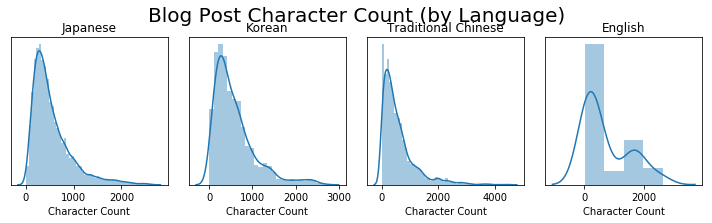

In [14]:
i = 1
plt.figure(figsize=(10,3))

languages = [l for l in list(blog.language.unique())]

for n, column in enumerate(lanlenseries):
    plt.subplot(1, 4, i)
    i = i + 1
    sns.distplot(column)
    plt.title(languages[n])
    plt.yticks([])
    plt.xlabel('Character Count')

plt.tight_layout()
plt.suptitle('Blog Post Character Count (by Language)',fontsize=20,y=1.02)
plt.show()

<a id="nlp"></a>

### <span style="color:darkred">NLP: Spell Check, Tokenization, Collocations, Parts of Speech, and Syntax</span>  <a href='#top'>(top)</a>

In [15]:
# from nltk.corpus import brown
# nltk.download('brown')

__Initialize Dictionary__

In [16]:
import re
from collections import Counter

# collects all the words loaded in a text object and breaks them into words using Regex
def words(text): return re.findall(r'\w+', text.lower())

# 1. populates the data set with real corpora...could be expanded to include user's personal content
# 2. counts the number of times a word occurs in the corpora
# WORDS = Counter(words(get_text('../data/dic/big.txt')))
WORDS = Counter(map(str.lower, brown.words()))

In [50]:
def P(word, N=sum(list(WORDS.values()))): 
    # Calculates the frequency count a word occurs in the overall WORDS list (i.e. 'the' has a high percentage)
    return WORDS[word] / N

def correction(word): 
    # Collects list of possible words only exist in WORDS and checks probability
    wordlist = candidates(word)
    finalcorrection = max(wordlist, key=P)
    
    possiblechoices = {}
    
    for w in wordlist:
        possiblechoices[w] = P(w)
        
    return finalcorrection

def blog_corrections(l):
    corrected = []
    for w in l:
        c = correction(w)
        if c != w:
            corrected.append([c,w])
    print('|',end='')
    return corrected

def candidates(word): 
    # (1) return word if in WORDS (i.e. correct), 
    # (2) return word if edits1 of word results in word in WORDS (i.e. typo)
    # (3) return word if edits2 on each word in edits1 results in a word in WORDS (i.e. 2 typos)
    # (4) return word if no words in WORDS were found

    answer = (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])
    return answer

def known(words): 
    # checks list of words to see if they exists in the WORDS database
    return set(w for w in words if w in WORDS)

def edits1(word):
    # initialize the letters
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    
    # Create a list of splits for the word so that four processes can be run at each split: (# of splits = length of word)
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    
    # 1. Create a list of one letter deletes from R side of split
    deletes    = [L + R[1:]               for L, R in splits if R]
    
    # 2. Create a list of words with switched letters using L,R from split for position
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    
    # 3. Create a list of words with replaced letters from R side of split using 26 letters * number splits
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    
    # 4. Create a list of words with letter inserts between L and R of split using 26 letters * number splits
    inserts    = [L + c + R               for L, R in splits for c in letters]
    
    # Returns the unique set of all real and unreal words created from each of the four processes
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    # If edits1 does not return a known word, edits2 check runs a process on each uknown word made in edits1
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def changes_list(l):
    cha = []
    for c,w in l:
        cha.append(changes(c,w))
    
    if len(cha) > 0:
        return list(np.concatenate(np.array(cha)))
    else:
        return []

def changes(check,word):
    changes = []
    for i,s in enumerate(difflib.ndiff(word, check)):
        if s[0]==' ': continue
        elif s[0]=='-':
            changes.append('-'+s[-1])
        elif s[0]=='+':
            changes.append('+'+s[-1])  
    return changes

def check_list(l):
    checks = []
    for c,w in l:
        checks.append(check(c,w))
        
    return checks
        

def check(check,word):
    c = True
    l = []
    letters = 'abcdefghijklmnopqrstuvwxyz'
    
    while c:
        if len(l) == 0:
            splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]

            deletes    = [L + R[1:]               for L, R in splits if R]
            if check in deletes:
                return 'del'

            transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
            if check in transposes:
                return 'tra'

            replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
            if check in replaces:
                return 'rep'

            inserts    = [L + c + R               for L, R in splits for c in letters]
            if check in inserts:
                return 'ins'
            
            l = list(set(deletes + transposes + replaces + inserts))
            
        else:
            for word in l:
                splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]

                deletes    = [L + R[1:]               for L, R in splits if R]
                if check in deletes:
                    return 'del'

                transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
                if check in transposes:
                    return 'tra'

                replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
                if check in replaces:
                    return 'rep'

                inserts    = [L + c + R               for L, R in splits for c in letters]
                if check in inserts:
                    return 'ins'
                
            c == False

__Initialize NLTK variables__

In [18]:
# brill_tagger

# Set NLP Variables
stop_words = set(sw.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
punct = re.compile(r'\w')
nountype = re.compile(r'N')
preplist = [i[0] for i in [('of', 268),('in', 209),('for', 123),('that', 81),('on', 70),('with', 70),('from', 51),
                           ('at', 45),('as', 44),('about', 42),('if', 39),('by', 36),('like', 31),('because', 19),
                           ('than', 17),('after', 17),('over', 15), ('without', 15),('before', 14),('so', 12),
                           ('though', 12),('since', 11),('into', 10), ('whether', 9),('while', 9),('during', 7),
                           ('under', 7), ('through', 6),('out', 6),('above', 6)]]

detlist = [i[0] for i in [('the', 25028), ('a', 16990), ('this', 5456), ('some', 2027), ('that', 1703), ('an', 1657), 
                          ('all', 1390), ('no', 946), ('these', 880), ('every', 664), ('any', 605), ('each', 449), 
                          ('another', 386),('those', 375),('both', 218),('either', 24),('neither', 10)]]

cclist = [i[0] for i in [('and', 15733),('but', 5601), ('or', 2314), ('nor', 33),('either', 20),
                         ('plus', 16), ('neither', 12)]]

# My personal syntax tree (needs improvement)
chunkGram = r"""
Question: {^<WP|WRB>|^<MD>}
Passive: {<RB>?<MD>?<RB>?<VBD|VB|VBP><RB>?<VBN><RB>?<VBN>?}
Active: {<RB>?<MD>?<RB>?<VB\w?>+<RB>?}
CP: {<JJ\w?>+}
NP:{(<DT|PRP.>|<CP>)<N\w+|PRP>}
NPC: {<NP><CC><NP>}
PP:{<IN><NP>}
INF:{<TO><VB><PP>?}
PRT: {<VBG>}
NPP: {<NP|PP|INF|PRT><NP|PP|INF|PRT>}
Subject: {<NP|NPP|NPC|N\w+|PRP>}<Active|Passive>
Object: <Active|Passive|Imperative>{<NP|NPP|NPC|N\w+|PRP>|(<IN><NPP|NP|N\w+|PRP>)}
Imperative: {^<Active>}
Adverbial: {<RB>}
"""

/Users/ryan/anaconda3/lib/python3.6/site-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning:

unclosed file <_io.BufferedReader name='/Users/ryan/nltk_data/corpora/stopwords/english'>



In [19]:
def tokendict(d):
    for sw in stop_words:
        if sw in d:
            del d[sw]
    return d

def onlygetPOS(val):
    tagged = nltk.pos_tag(nltk.word_tokenize(val)) 
    return [v if punct.search(v) else 'PUNCT' for i,v in tagged ]

def onlygetCC(val):
    tagged = nltk.pos_tag(nltk.word_tokenize(val))   
    return [i for i,v in tagged if i in cclist]

def onlygetDET(val):
    tagged = nltk.pos_tag(nltk.word_tokenize(val))   
    return [i for i,v in tagged if i in detlist]

def onlygetPREP(val):
    tagged = nltk.pos_tag(nltk.word_tokenize(val))
    return [i for i,v in tagged if i in preplist]

def getPOS(val):
    words = nltk.word_tokenize(val)
    return nltk.pos_tag(words)

def getSYNTAX(val):
    chunkParser = nltk.RegexpParser(chunkGram)
    chunked = chunkParser.parse(getPOS(val))
    return chunked

def getNOUNTYPE(val):
    tagged = nltk.pos_tag(nltk.word_tokenize(val))
    return [v for i,v in tagged if nountype.search(v)]

In [20]:
%%time
blog['tokens'] = blog.content.str.lower().apply(tokenizer.tokenize)

CPU times: user 502 ms, sys: 38.6 ms, total: 541 ms
Wall time: 568 ms


In [21]:
%%time
blog['pos'] = blog.content.str.lower().apply(onlygetPOS)
blog['determiners'] = blog.content.str.lower().apply(onlygetDET)
blog['prepositions'] = blog.content.str.lower().apply(onlygetPREP)
blog['complementizer'] = blog.content.str.lower().apply(onlygetCC)
blog['ntype'] = blog.content.str.lower().apply(getNOUNTYPE)

CPU times: user 4min 46s, sys: 2.18 s, total: 4min 48s
Wall time: 4min 52s


In [39]:
%%time
blog['corrections'] = blog.tokens.apply(blog_corrections)

6031127575916320346850354095120719911954114767956374328144421185528642354188113247971632786087839782159821828318721518419616963842401871851901951641841088107722038385410168113134742839173271523875611137465494276197307148902089297113100212240154697556413322224911827103133189124391116759103122115103633801672751965150343103202490120247203209216781419713314014316820319763360698021565918284264287665691951295610456574868666451612642433635965977473515841931991976465627552574480106123126921351364411994142175769413922816860892138420257378777519610758304155122456394180811135513235839718166341445926518734437228231225204333248067015245911831328223023720291742726282934425685554712249821052048726024447185428786776424314221716314110938345518391214390124108621477519178184252621458421310299203212143217112960234114449643631383097130126154109324326916612713896156801331298083127133182534148822760192859192581016775801083937895427281117215158476123138651751631521161328415312522987272142241091531941591522695

9474343744647913763431533636551479515856319429511412210589102235352301401109013538976633291801373012441521176645115168173173159171220161507553636110596170187703825767382275338345813879150429235633031666823294320216143374110585110814214420621929722981203248126179131128171385882742381994347394128746989767044356208013384322042532202412073321084855733682941892752014136927035526318380240336253186201032775911317810119210011818410611512612461192104106871781078224677378626248157108157180487415596798280723310842956769441445654763510496582015814055125211100121841413731168942231158275220629813176109101965940337215122949271621403290638425682821218815714832117255249124999608170622560274031531396611321024262125122611171418513957921691323971431826511610550577374193664742102363217814456662681574235152234495522692755321239801281497214063181125866757611247931306460378554897312019212215913711811611733671275211115914813314023344381479959456314306919142423312574816632395231266010613985658418566718761639976

6426050916247425122010618717593347092576755238150738932224814023231111701011471058240264198116200339376130102195422715463228243649323723986992481541071151314212776298147961551396111841341052848316114117774153151492216321482294218102167175119726761371183238519135511102723112240244168153681913310590110591438100143277114716573421217911816259276855473024321827413871735325750726445305870301268440523244577632135509457462002338154957165716315524610110224637114185171634742289214524146465337336730143110167204391921161791920251014334303577147126631782324132386064318568128363943504054103847067103477721423554216882452560124167281521620358146454732519511856535610141367413485621154659701675114916313433252922247135155745184664863469075301471731171439085108954710413224529851619110328195182116117355685531115675238785969178157561658390336539312527484616921428403581101467453321251296058521101528332514140364447353724461592355299361159291614785114153193993016920929127841061235071127432636760954453663387373

1041125896177734792408123748487231257262474597237321020193216173104190978581396540435254185296193721658114981177670788011815412492154110966945163781847123349986461282161301582397135141182116141901501137471641311103137823654212599459356367381109122204233147741331684411011322019814410614897120671098712315614611922018265526783116508111659161010999440486155281693277527438025427044024312827093831091661461469072645914116819452742123773283757329223313633192939517123916131113465155565148614437938260511454154101172344182154176831988029414015516810439912154274269915312514474118343888389361912286373611186341223813379111922414619171236916668117133409061174224166474747252362192910626124645491455442198244152311102818785234987463134801291011691841076883721516412816123196273465351731771423684921052991921131352239127284787110124119429340257328182924259017416511205164765660173711342272051213941814261764275949083465929412240219916157474514214231223871383714511611617010811213935597753195939349853214821117

In [41]:
%%time
blog['checks'] = blog.corrections.apply(check_list)

CPU times: user 2min 39s, sys: 584 ms, total: 2min 39s
Wall time: 2min 40s


In [51]:
blog['changes'] = blog.corrections.apply(changes_list)

In [52]:
blog.head()

,id,time,title,content,language,char_count,tokens,pos,determiners,prepositions,complementizer,ntype,corrections,changes,checks
0,1,2018-03-15 23:52:01.424272+00:00,I'm going to Silicon Valley!,I will visit Silicon Valley in California bet...,Japanese,313,"[i, will, visit, silicon, valley, in, californ...","[NN, MD, VB, JJ, NN, IN, NN, IN, JJ, NN, PRP$,...","[that, that]","[in, that, that, with, if, in]","[and, and, and, and, or]","[NN, NN, IN, NN, IN, NN, NNS, IN, NN, IN, NNS,...","[[with, wth]]",[+i],[ins]
1,1,2018-03-15 23:52:06.279421+00:00,Sightseeing in Kyoto,My parents want to take their Chinese guests ...,Japanese,168,"[my, parents, want, to, take, their, chinese, ...","[PRP$, NNS, VBP, TO, VB, PRP$, JJ, NNS, TO, VB...","[the, any]","[in, if]",[],"[NNS, NNS, IN, NN, NN, IN, NNS, NN]",[],[],[]
2,1,2018-03-15 23:52:09.582504+00:00,Shaku-gan no SHANA,Do you know a Japanese animation (and novel) ...,Japanese,690,"[do, you, know, a, japanese, animation, and, n...","[VB, PRP, VB, DT, JJ, NN, PUNCT, CC, RB, PUNCT...","[a, no, a, the, the, some, no, no, the, the, t...","[of, of, into, if, from, on, in, with, of, bef...","[and, but, and]","[NN, NN, IN, NN, NN, IN, NN, IN, IN, NN, IN, I...","[[shake, shaku], [an, gan], [shann, shana], [a...","[-u, +e, -g, -a, +n, -m, +a, -k, +n, -k, -u, +...","[rep, del, rep, rep, rep, del, rep, rep, del, ..."
3,2,2018-03-16 00:00:59.456895+00:00,Unlucky,I went to watch a featherweight throne jump-o...,Japanese,325,"[i, went, to, watch, a, featherweight, throne,...","[JJ, VBD, TO, VB, DT, JJ, NN, NN, IN, DT, JJ, ...","[a, the, the, the, the, the, the, a]","[of, on, as, of, for, with, of, for, with]","[and, but]","[NN, NN, IN, NN, NN, IN, NN, NN, NN, IN, NN, I...","[[nehf, njkf], [canada, hanawa], [blizzard, bl...","[-j, -k, +e, +h, -h, +c, -w, +d, +z]","[rep, rep, ins]"
4,2,2018-03-16 00:01:03.120751+00:00,Stone Art???,There is a traditional custum that a blood re...,Japanese,340,"[there, is, a, traditional, custum, that, a, b...","[EX, VBZ, DT, JJ, NN, IN, DT, NN, NN, VBD, JJ,...","[a, that, a, some, an, the, the]","[that, in, from, in]","[and, or]","[NN, IN, NN, NN, NNS, NN, NN, IN, NN, NNS, IN,...","[[custom, custum], [canadian, canadaian]]","[-u, +o, -a]","[rep, del]"


__Bar Plots__

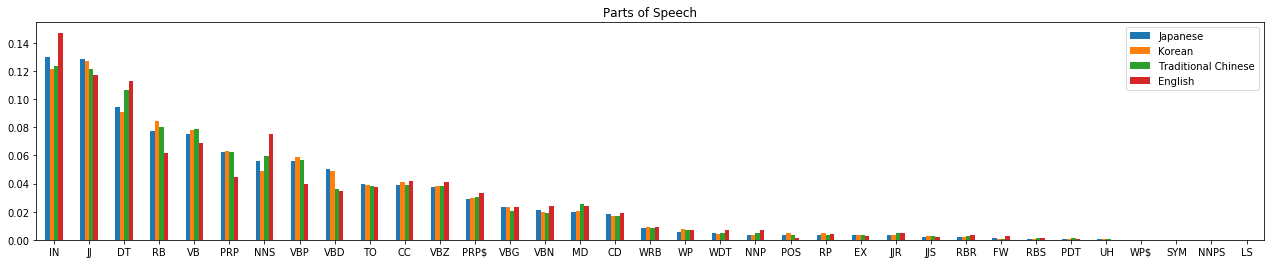

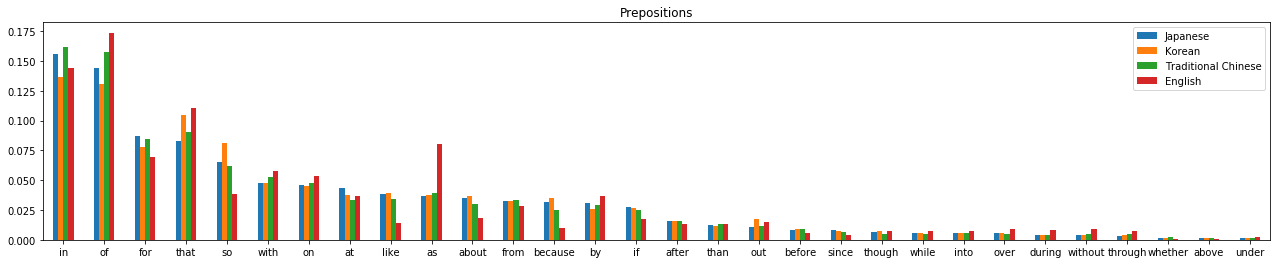

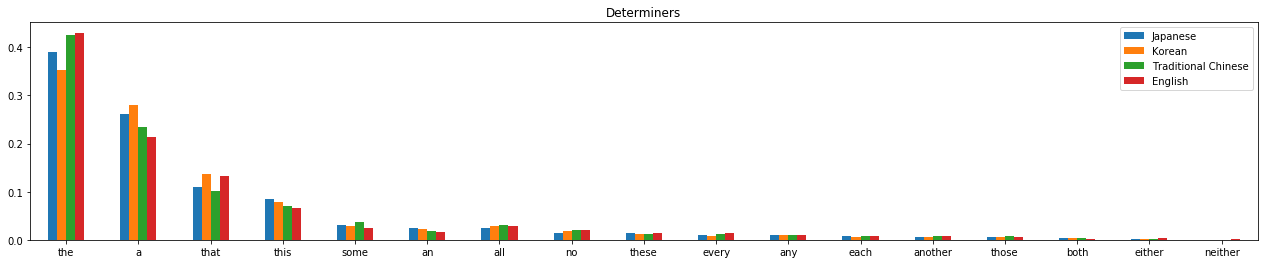

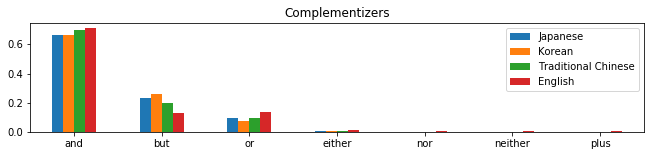

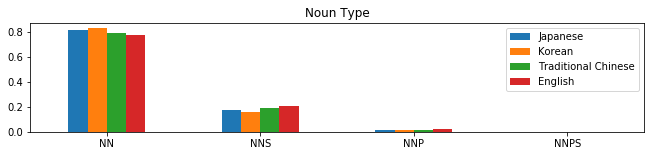

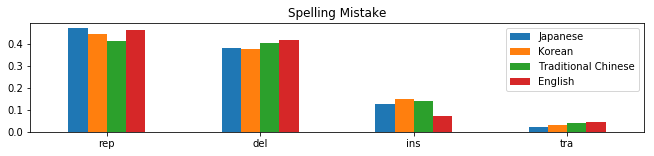

In [70]:
lang = list(blog.language.unique())

# Parts of Speech
posDF = pd.DataFrame(data = [Counter(np.concatenate(np.array(blog.pos[blog.language == l]))) for l in lang], 
                     index = [l for l in list(blog.language.unique())]
                    ).T.fillna(0).drop(['NN','PUNCT']).sort_values(by='Japanese',ascending=False)
for l in posDF:
    posDF[l] = posDF[l]/posDF[l].sum()

    
# Noun Type
ntypeDF = pd.DataFrame(data = [Counter(np.concatenate(np.array(blog.ntype[blog.language == l]))) for l in lang], 
                     index = [l for l in list(blog.language.unique())]
                    ).T.fillna(0).drop(['IN','VBN']).sort_values(by='Japanese',ascending=False)
for l in ntypeDF:
    ntypeDF[l] = ntypeDF[l]/ntypeDF[l].sum()


# Prepositions
prepDF = pd.DataFrame(data = [Counter(np.concatenate(np.array(blog.prepositions[blog.language == l]))) for l in lang], 
                      index = [l for l in list(blog.language.unique())]
                     ).T.fillna(0).sort_values(by='Japanese',ascending=False)
for l in prepDF:
    prepDF[l] = prepDF[l]/prepDF[l].sum()
    
    
# Determiners
detDF = pd.DataFrame(data = [Counter(np.concatenate(np.array(blog.determiners[blog.language == l]))) for l in lang], 
                     index = [l for l in list(blog.language.unique())]
                    ).T.fillna(0).sort_values(by='Japanese',ascending=False)
for l in detDF:
    detDF[l] = detDF[l]/detDF[l].sum()
    
# complementizers
ccDF = pd.DataFrame(data = [Counter(np.concatenate(np.array(blog.complementizer[blog.language == l]))) for l in lang], 
                      index = [l for l in list(blog.language.unique())]
                     ).T.fillna(0).sort_values(by='Japanese',ascending=False)
for l in ccDF:
    ccDF[l] = ccDF[l]/ccDF[l].sum()
    
    
# checks
checksDF = pd.DataFrame(data = [Counter(np.concatenate(np.array(blog.checks[blog.language == l]))) for l in lang], 
                      index = [l for l in list(blog.language.unique())]
                     ).T.fillna(0).sort_values(by='Japanese',ascending=False)
for l in checksDF:
    checksDF[l] = checksDF[l]/checksDF[l].sum()
    
# spelltype
lettersDF = pd.DataFrame(data = [Counter(np.concatenate(np.array(blog.changes[blog.language == l]))) for l in lang], 
                      index = [l for l in list(blog.language.unique())]
                     ).T.fillna(0).sort_values(by='Japanese',ascending=False)
for l in lettersDF:
    lettersDF[l] = lettersDF[l]/lettersDF[l].sum()

# Graphs
posDF.plot.bar(rot=0,figsize=(22, 4))
plt.title('Parts of Speech')
plt.show()

prepDF.plot.bar(rot=0,figsize=(22, 4))
plt.title('Prepositions')
plt.axis()
plt.show()

detDF.plot.bar(rot=0,figsize=(22, 4))
plt.title('Determiners')
plt.show()

ccDF.iloc[:,0:4].plot.bar(rot=0,figsize=(11, 2))
plt.title('Complementizers')
plt.show()

ntypeDF.iloc[:,0:4].plot.bar(rot=0,figsize=(11, 2))
plt.title('Noun Type')
plt.show()

checksDF.iloc[:,0:4].plot.bar(rot=0,figsize=(11, 2))
plt.title('Spelling Mistake')
plt.show()

In [71]:
lettersDF = lettersDF.iloc[0:40]

In [150]:
lettersDF.index

Index(['+e', '+a', '-t', '-n', '-i', '-a', '-e', '-s', '-o', '+l', '+s', '+t',
       '+o', '+r', '+h', '-l', '+i', '-m', '-u', '+n', '-k', '-c', '-r', '-v',
       '+d', '-p', '-y', '-g', '+u', '-h', '-d', '+c', '+w', '+m', '-b', '-0',
       '+p', '-j', '-w', '+y'],
      dtype='object')

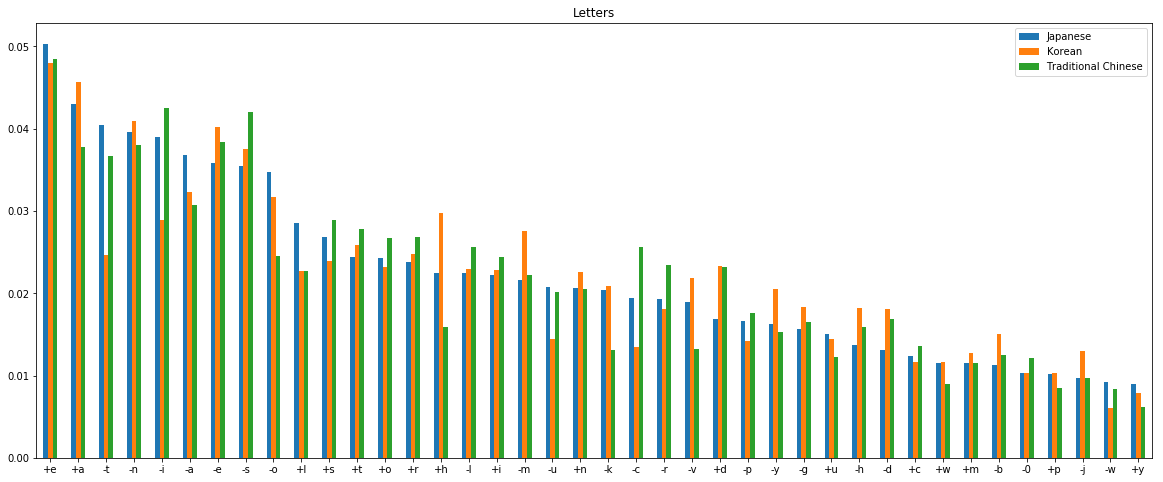

In [73]:
lettersDF.iloc[:,0:3].plot.bar(rot=0,figsize=(20, 8))
plt.title('Letters')
plt.show()

'Multi class classification problem' 'Mutually exclusive classes'

In [ ]:
# Run Test on Japanese/English vs Chinese/English

__Misc Raw Code__

__Correlations__

__A. Scatterplot using univariate and bivariate methods__

_Before cleaning data_

In [ ]:
# Make the scatterplot matrix
featurelist = ['age','trestbps','chol','thalach','oldpeak','exang','num']
locations = ['cleveland', 'hungarian', 'switzerland', 'va']
palette = ['r','b','g','y']

i = 1
fig=plt.figure(figsize=(15,10))

for column in featurelist:
    plt.subplot(4, 2, i)
    i = i + 1
    for idx, location in enumerate(locations):
        sns.kdeplot(heartdf[column].loc[heartdf['location'] == location], color = palette[idx])
    plt.title(column)
    plt.legend(locations)

plt.show()

_After cleaning data_

In [ ]:
# Make the scatterplot matrix
featurelist = ['age','trestbps','chol','thalach','oldpeak']


g = sns.PairGrid(data=heart, diag_sharey=False, hue="location", vars=featurelist, palette=['r','b','g','y'])
g.map_offdiag(plt.scatter, alpha=.5)
g.map_diag(sns.kdeplot, lw=3)

g.add_legend()

plt.show()

<a id="sec3"></a>

###  <span style="color:darkblue">C. Statistical Significance <a href='#top'>(top)</a>

__A. Mood’s Median test (2+ Non-Normally Distributed Independent Samples)__

_ __Null Hypothesis:__ Assumes no statistically significant difference between samples._

In [ ]:
stat, p, med, tbl = median_test(heart['chol'].loc[heart['location'] == 'hungarian'],heart['chol'].loc[heart['location'] == 'va'],heart['chol'].loc[heart['location'] == 'cleveland'])
print(stat,med)
print(p)

p-value is not less than 5% and doesn't disprove the null hypothesis. There may not be statistical significance between Hungarian, VA, and Cleveland cholesterol samples.

In [ ]:
stat, p, med, tbl = median_test(heart['oldpeak'].loc[heart['location'] == 'hungarian'],heart['oldpeak'].loc[heart['location'] == 'va'],heart['oldpeak'].loc[heart['location'] == 'cleveland'])
print(stat,med)
print(p)

p-value is less than 5% and disproves the null hypothesis. The differences between Hungarian, VA, and Cleveland oldpeak samples are statistically significant.

__B. One-Way AnovaTest (2+ Normally Distributed Independent Samples)__

_ __Null Hypothesis:__ Assumes no statistically significant difference between samples._

In [ ]:
f, p = f_oneway(heart['chol'].loc[heart['location'] == 'hungarian'],heart['chol'].loc[heart['location'] == 'va'],heart['chol'].loc[heart['location'] == 'cleveland'])

print("F-Value: {}, p:{}".format(f,p))

p-value is not less than 5% and doesn't disprove the null hypothesis. There may not be statistical significance between Hungarian, VA, and Cleveland samples.

In [ ]:
f, p = f_oneway(heart['oldpeak'].loc[heart['location'] == 'hungarian'],heart['oldpeak'].loc[heart['location'] == 'va'],heart['oldpeak'].loc[heart['location'] == 'cleveland'])

print("F-Value: {}, p:{}".format(f,p))

p-value is less than 5% and disproves the null hypothesis. The differences between Hungarian, VA, and Cleveland oldpeak samples are statistically significant.

<a id="sec3"></a>

# <span style="color:darkblue">Models:</span>  <a href='#top'>(top)</a>

In [202]:
postags = blog.pos.str.join('|').str.get_dummies().add_prefix('tags_')

dettags = blog.determiners.str.join('|').str.get_dummies().add_prefix('tags_')
checktags = blog.checks.str.join('|').str.get_dummies().add_prefix('tags_')
preptags = blog.prepositions.str.join('|').str.get_dummies().add_prefix('tags_')
comptags = blog.complementizer.str.join('|').str.get_dummies().add_prefix('tags_')
blog_data = pd.DataFrame(blog[['char_count','language']])


letters = ['tags_'+let for let in ['+e','+a','-t', '-n', '-i', '-a', '-e', '-s', '-o', '+l', '+s', '+t', '+o', '+r', '+h', '-l', '+i', '-m', '-u', '+n', '-k', '-c', '-r', '-v', '+d', '-p', '-y', '-g', '+u', '-h', '-d', '+c', '+w', '+m', '-b', '-0', '+p', '-j', '-w', '+y']]
lettertags = (blog.changes.str.join('|').str.get_dummies().add_prefix('tags_'))[letters]
tags = [postags,dettags,checktags,preptags,comptags,blog_data]
features = tags[0]
tags = tags[1:]
for i in range(len(tags)):
    features = features.merge(tags[i], how='outer', left_index=True, right_index=True)

In [203]:
features.head()

,tags_CC,tags_CD,tags_DT,tags_EX,tags_FW,tags_IN,tags_JJ,tags_JJR,tags_JJS,tags_LS,...,tags_without,tags_and,tags_but,tags_either_y,tags_neither_y,tags_nor,tags_or,tags_plus,char_count,language
0,1,0,0,0,0,1,1,0,0,0,...,0,1,0,0,0,0,1,0,313,Japanese
1,0,0,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,168,Japanese
2,1,1,1,0,1,1,1,0,0,0,...,1,1,1,0,0,0,0,0,690,Japanese
3,1,0,1,0,0,1,1,0,0,0,...,0,1,1,0,0,0,0,0,325,Japanese
4,1,0,1,1,0,1,1,0,0,0,...,0,1,0,0,0,0,1,0,340,Japanese


In [204]:
y = features['language'].values.reshape(-1, 1).ravel()

In [209]:
X = features[features.columns[~features.columns.str.contains('language')]]


print(np.shape(y))
print(np.shape(X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)  

(13339,)
(13339, 96)


In [210]:
X.head()

,tags_CC,tags_CD,tags_DT,tags_EX,tags_FW,tags_IN,tags_JJ,tags_JJR,tags_JJS,tags_LS,...,tags_with,tags_without,tags_and,tags_but,tags_either_y,tags_neither_y,tags_nor,tags_or,tags_plus,char_count
0,1,0,0,0,0,1,1,0,0,0,...,1,0,1,0,0,0,0,1,0,313
1,0,0,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,168
2,1,1,1,0,1,1,1,0,0,0,...,1,1,1,1,0,0,0,0,0,690
3,1,0,1,0,0,1,1,0,0,0,...,1,0,1,1,0,0,0,0,0,325
4,1,0,1,1,0,1,1,0,0,0,...,0,0,1,0,0,0,0,1,0,340


<a id="seca"></a>

### <span style="color:darkblue">A. LR - Ordinary Least Squares</span>  <a href='#top'>(top)</a>

> Target is binary so this model may not be appropriate <br>Many features are binary so model may not be appropriate <br>Predicted values are not binary and need to be rounded up/down

<a id="secb"></a>

### <span style="color:darkblue">B. LR - Logistic Regression</span>  <a href='#top'>(top)</a>

> Target is binary so logistic regression will operate on probabilities

In [213]:
%%capture timeB --no-stderr
%%time

# Instantiate our model.
lregr = linear_model.LogisticRegression()

# Fit our model to our data.
lregr.fit(X_train, y_train)

In [214]:
# Display the attributes
print('Coefficients: \n')
pprint(list(zip(X.columns,lregr.coef_[0])))
print('\nIntercept: \n', lregr.intercept_)
coef = list(zip(X.columns,lregr.coef_[0]))

Coefficients: 

[('tags_CC', -0.5290420671702504),
 ('tags_CD', -0.30881905853976377),
 ('tags_DT', -0.16434116094778609),
 ('tags_EX', -0.41002323761168474),
 ('tags_FW', 0.4778342327135528),
 ('tags_IN', 0.25993632008755285),
 ('tags_JJ', -0.28012403309315714),
 ('tags_JJR', -0.03497957983856205),
 ('tags_JJS', -0.25850812195363565),
 ('tags_LS', -0.008869964451686963),
 ('tags_MD', 0.4534999009536191),
 ('tags_NN', -0.5110562891703501),
 ('tags_NNP', 0.5963427708847423),
 ('tags_NNPS', -0.07592788505183881),
 ('tags_NNS', -0.04919198889535769),
 ('tags_PDT', -0.34615321847042413),
 ('tags_POS', -0.27817588645799707),
 ('tags_PRP', 0.1423983972043038),
 ('tags_PRP$', -0.22239757509451286),
 ('tags_PUNCT', -0.4907749506669981),
 ('tags_RB', -1.0971730252254341),
 ('tags_RBR', 0.5483756064938502),
 ('tags_RBS', 0.5174146712481703),
 ('tags_RP', 0.42328522723463713),
 ('tags_SYM', -0.18168032539433068),
 ('tags_TO', -0.6993870535600082),
 ('tags_UH', -0.45501579274483095),
 ('tags_VB', 

In [215]:
print(lregr.score(X_test,y_test))
scoreB = lregr.score(X_test,y_test)

0.6646676661669165


In [216]:
lregr.score(X_test,y_test)

0.6646676661669165

<a id="secb1"></a>

#### <span style="color:darkred">B1. Lasso</span>  <a href='#top'>(top)</a>

<a id="secb2"></a>

#### <span style="color:darkred">B2. Ridge</span>  <a href='#top'>(top)</a>

_Lasso and Ridge are not good predictors so should I just be using them for parameter manipulation?_

<a id="secc"></a>

### <span style="color:darkblue">C. K Nearest Neighbors</span>  <a href='#top'>(top)</a>

> Can handle discrete values for target <br>Quantitative values are limited (not continuous) and might be problematic for nearest neighbors

In [218]:
%%capture timeC --no-stderr
%%time
neighbors = KNeighborsClassifier(n_neighbors=5)
neighbors.fit(X_train, y_train.ravel())

In [219]:
print(neighbors.score(X_test,y_test))
scoreC = neighbors.score(X_test,y_test)

0.6221889055472264


<a id="secc"></a>

### <span style="color:darkblue">D. Naive Bayes - Bernoulli</span>  <a href='#top'>(top)</a>

> Should be best for boolean classification but has lowest prediction score

In [220]:
%%capture timeD --no-stderr
%%time
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

In [221]:
print(bnb.score(X_test,y_test))
scoreD = bnb.score(X_test,y_test)

0.5657171414292853


<a id="sece"></a>

### <span style="color:darkblue">E. Decision Tree</span>  <a href='#top'>(top)</a>

> Visualizes most important features by hierarchy <br>Longer processing time

In [240]:
%%capture timeE --no-stderr
%%time

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=3,
    max_depth=4)

decision_tree.fit(X_train, y_train)

In [242]:
lang

['Japanese', 'Korean', 'Traditional Chinese', 'English']

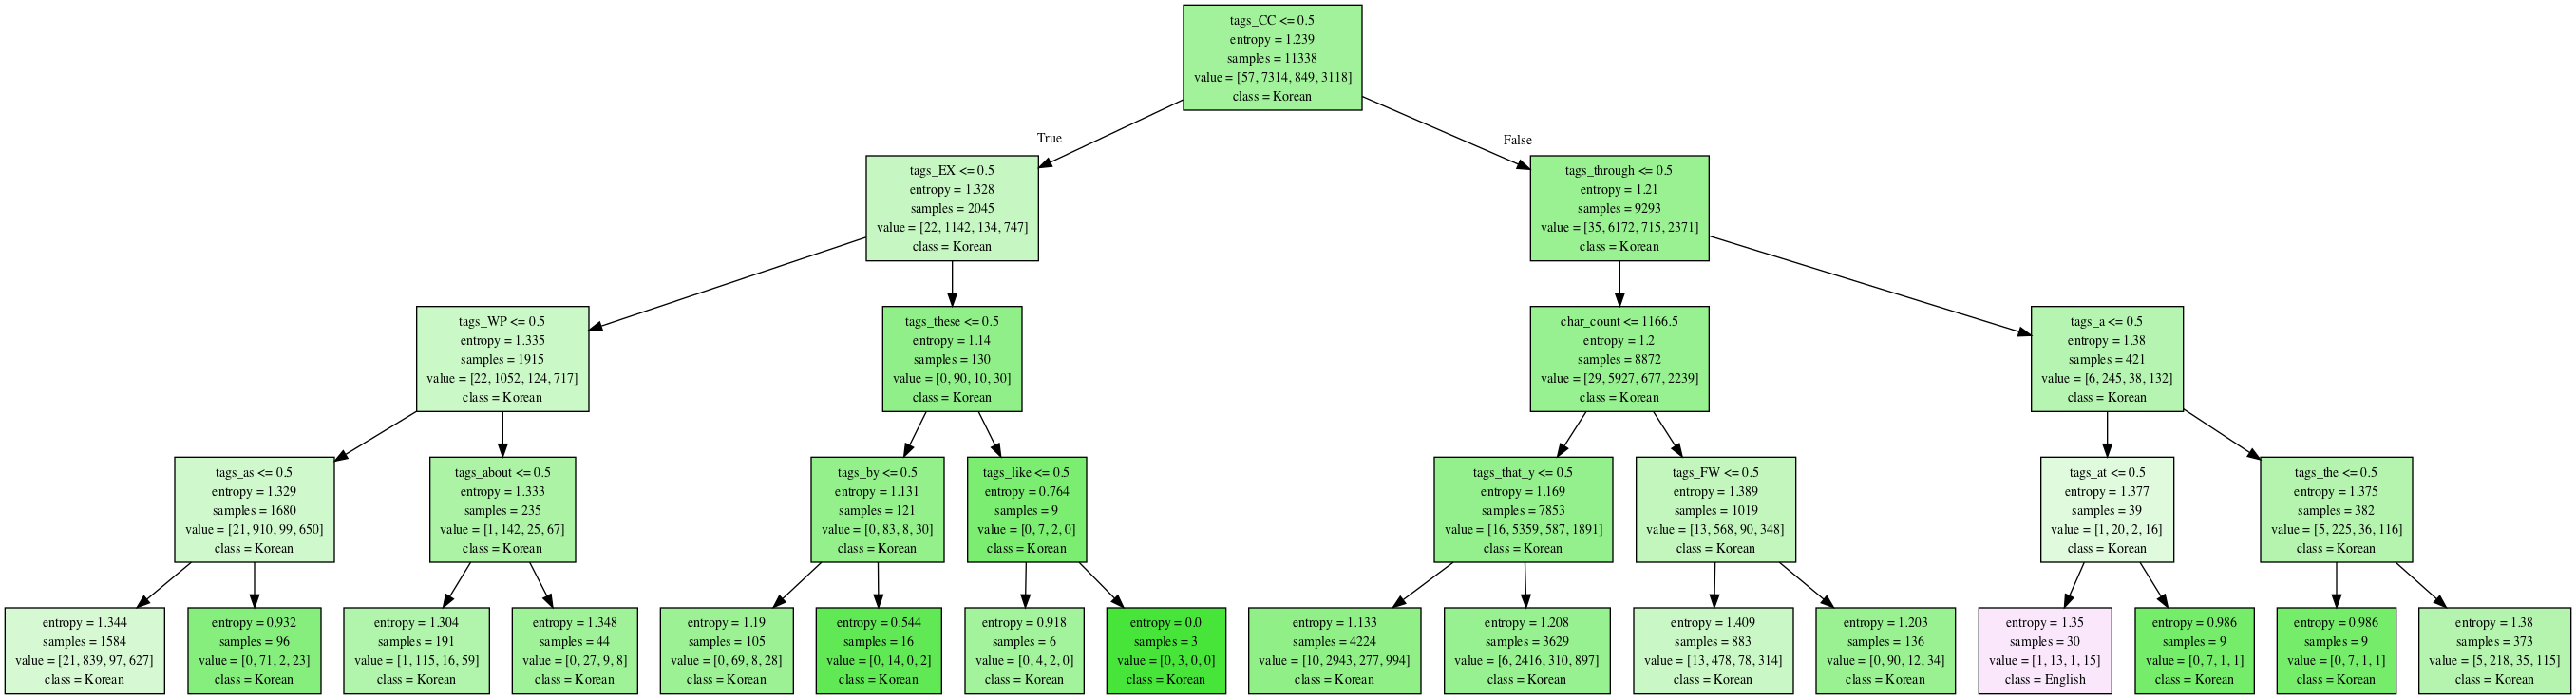

In [245]:
# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['Japanese', 'Korean', 'Traditional Chinese', 'English'],
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [246]:
scoreE=decision_tree.score(X_test,y_test)
decision_tree.score(X_test,y_test)

0.6291854072963519

_Good visualization of important features and presentation of entropy weighting_

<a id="secf"></a>

### <span style="color:darkblue">F. Random Forest</span>  <a href='#top'>(top)</a>

> Runs decision tree multiple times for best output <br>Longest processing time

In [225]:
%%capture timeF --no-stderr
%%time

rfc = ensemble.RandomForestClassifier(n_estimators=20)
rfc.fit(X_train,y_train.ravel())

In [226]:
cvs = cross_val_score(rfc, X_test, y_test.ravel(), cv=5)
print(cvs)
scoreF = cvs.sum()/len(cvs)

[0.64089776 0.68       0.6525     0.6475     0.62      ]


In [227]:
rfc.score(X_train,y_train)

0.9960310460398659

In [228]:
rfc.feature_importances_
importance = list(zip(X.columns,rfc.feature_importances_))

<a id="sec4"></a>

# <span style="color:darkblue">4. Model Comparison</span>  <a href='#top'>(top)</a>

In [229]:
print('OLS Coefficients:')
pprint(coef)
print('\nDecision Tree Importance:')
pprint(importance)

OLS Coefficients:
[('tags_CC', -0.5290420671702504),
 ('tags_CD', -0.30881905853976377),
 ('tags_DT', -0.16434116094778609),
 ('tags_EX', -0.41002323761168474),
 ('tags_FW', 0.4778342327135528),
 ('tags_IN', 0.25993632008755285),
 ('tags_JJ', -0.28012403309315714),
 ('tags_JJR', -0.03497957983856205),
 ('tags_JJS', -0.25850812195363565),
 ('tags_LS', -0.008869964451686963),
 ('tags_MD', 0.4534999009536191),
 ('tags_NN', -0.5110562891703501),
 ('tags_NNP', 0.5963427708847423),
 ('tags_NNPS', -0.07592788505183881),
 ('tags_NNS', -0.04919198889535769),
 ('tags_PDT', -0.34615321847042413),
 ('tags_POS', -0.27817588645799707),
 ('tags_PRP', 0.1423983972043038),
 ('tags_PRP$', -0.22239757509451286),
 ('tags_PUNCT', -0.4907749506669981),
 ('tags_RB', -1.0971730252254341),
 ('tags_RBR', 0.5483756064938502),
 ('tags_RBS', 0.5174146712481703),
 ('tags_RP', 0.42328522723463713),
 ('tags_SYM', -0.18168032539433068),
 ('tags_TO', -0.6993870535600082),
 ('tags_UH', -0.45501579274483095),
 ('tags_VB'

In [230]:
models = ['Ordinary Least Squares','Logistic Regression','K Nearest Neigbbors','Naive Bayes Bernoulli','Decision Tree','Random Forest']
times = [timeA,timeB,timeC,timeD,timeE,timeF]
timesfinal = []
for time in times:
    timesfinal.append((((time.stdout.splitlines())[0].split(','))[0].split('user '))[1])
score = [str(scoreA)[0:7]+('*'),scoreB,scoreC,scoreD,scoreE,scoreF]

dfModels = pd.DataFrame(index=models)
dfModels['cpu time'] = timesfinal
dfModels['score'] = score
dfModels

IndexError: list index out of range